In [ ]:
%%capture
%load_ext autoreload
%autoreload 2
%reset -f

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

from harmonic_balance import aft, freq, utils

ndarray = np.ndarray

## Define system

In [ ]:
omega = 2
n = 2

ks = (1, 1)
dofs = (0, 1)
is_cosines = (1, 0)
coefficients = (2, 1)

## Set harmonic balance parameters

In [ ]:
NH = 30
N = 128

b_ext = freq.get_b_ext(NH, n, ks, dofs, is_cosines, coefficients)


## Verify alternating frequency/time

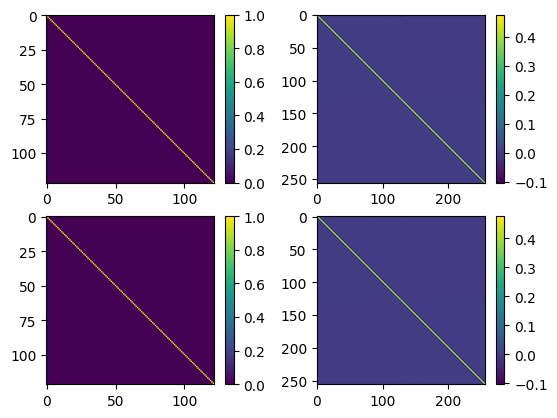

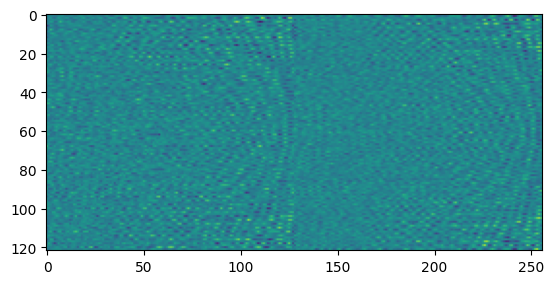

(np.float64(1.503778542040588e-14),
 np.float64(9.641770357974225e-17),
 np.float64(1.854604218230955e-14),
 np.float64(1.4726578861308808e-16))

In [ ]:
gamma = aft.get_gamma(omega, NH, n, N)
inv_gamma = aft.get_inv_gamma(omega, NH, n, N)

fig, axs = plt.subplots(2, 2)
images = list()
np_inv_gamma = np.linalg.pinv(gamma.toarray())
images.append(axs[0, 0].imshow((np_inv_gamma @ gamma).real))
images.append(axs[0, 1].imshow((gamma @ np_inv_gamma).real))
images.append(axs[1, 0].imshow((inv_gamma @ gamma).real.toarray()))
images.append(axs[1, 1].imshow((gamma @ inv_gamma).real.toarray()))
[fig.colorbar(image) for image in images]
plt.show()

plt.imshow((inv_gamma - np.linalg.pinv(gamma.toarray())).real)
plt.show()


(
    utils.max_abs(gamma @ np_inv_gamma @ gamma - gamma),
    utils.max_abs(np_inv_gamma @ gamma @ np_inv_gamma - np_inv_gamma),
    utils.max_abs(gamma @ inv_gamma @ gamma - gamma),
    utils.max_abs(inv_gamma @ gamma @ inv_gamma - inv_gamma),
)

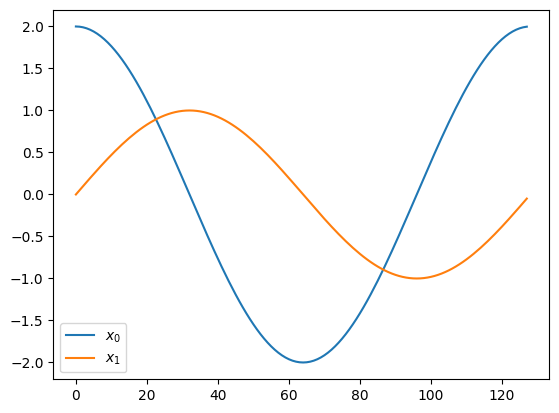

np.float64(1.7615132494473541e-15)

In [ ]:
time = aft.time_from_freq(n, gamma, b_ext)
x0, x1 = utils.extract_dofs_time(time, n)
plt.plot(x0.toarray(), label="$x_0$")
plt.plot(x1.toarray(), label="$x_1$")
plt.legend()
plt.show()

utils.max_abs(aft.freq_from_time(inv_gamma, time) - b_ext)